In [64]:
from datetime import datetime
import pandas as pd

cfg = {
    "start": datetime(2025, 6, 28, 19, 45),
    "end":   datetime(2025, 6, 28, 21, 15),
    "db": "wifi_data_db",
    "collection": "wifi_client_data_global",
    "ap_positions": {
        "freind1": (0, 0),
        "freind2": (4, 0),
        "freind3": (2, 4),
    }
}

from pymongo import MongoClient
client = MongoClient("mongodb://localhost:28910/")
db = client["wifi_fingerprinting_data_raw"]
collection = db["equilatero_grande_outdoor"]
df = pd.DataFrame(list(collection.find({})))
client.close()


def filter_by_axis(df:pd.DataFrame,x:int=None, y:int=None):

    if x != None:
        df = df[df["location_x"] == x]
    
    if y != None:
        df = df[df["location_y"] == y]
    
    return df
    

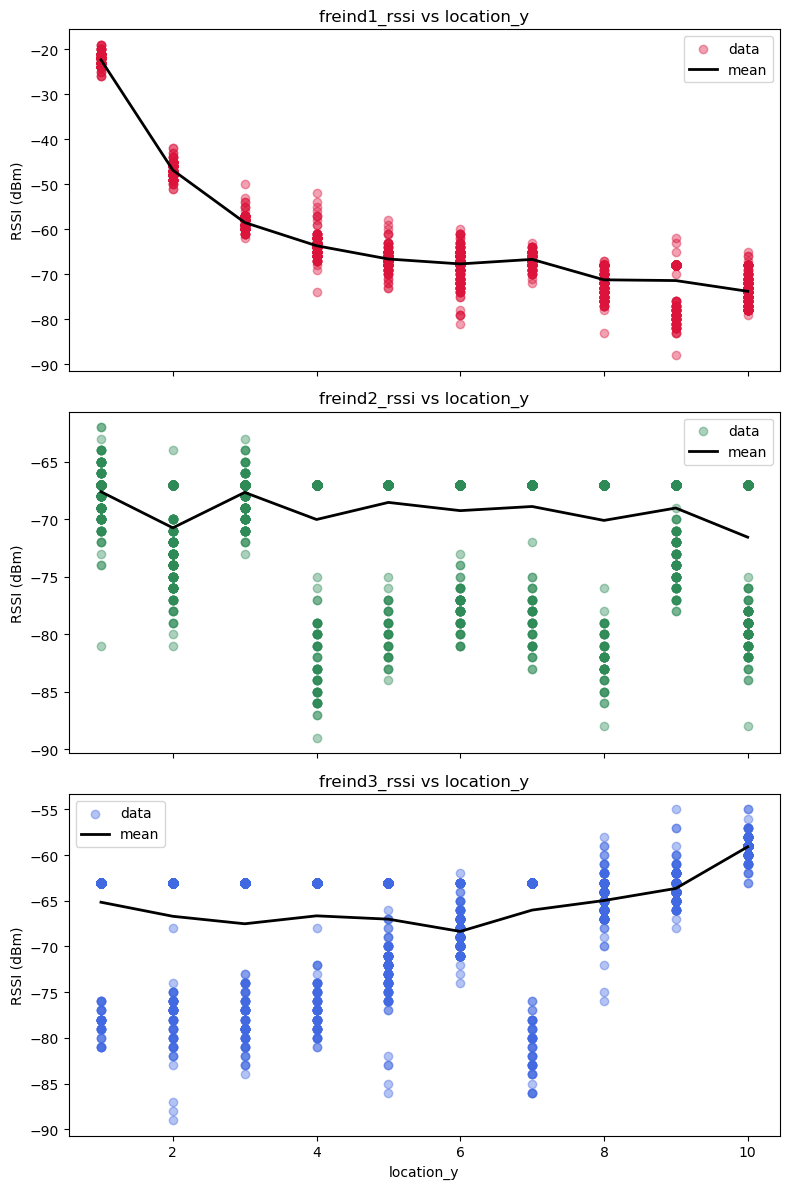

                           _id  location_x  location_y     timestamp  \
0     68ad8e2edd938db56175d42e           1           8  1.751136e+09   
1     68ad8e2edd938db56175d42f           1           7  1.751136e+09   
2     68ad8e2edd938db56175d430           1           3  1.751136e+09   
3     68ad8e2edd938db56175d431           1           9  1.751136e+09   
4     68ad8e2edd938db56175d432           1           1  1.751136e+09   
...                        ...         ...         ...           ...   
2985  68ad8e2edd938db56175dfd7           1           5  1.751137e+09   
2986  68ad8e2edd938db56175dfd8           1           2  1.751137e+09   
2987  68ad8e2edd938db56175dfd9           1           6  1.751137e+09   
2988  68ad8e2edd938db56175dfda           1           3  1.751137e+09   
2989  68ad8e2edd938db56175dfdb           1           4  1.751137e+09   

      freind1_rssi  freind3_rssi  freind2_rssi  
0              -71           -64           -81  
1              -65           -63     

In [65]:
import matplotlib.pyplot as plt
import numpy as np

def mapping_rssi(df, axis):
    if axis not in ["x", "y"]:
        raise Exception("axis must be 'x' or 'y'")

    location = "location_x" if axis == "x" else "location_y"

    filtered = df[[location, "freind1_rssi", "freind2_rssi", "freind3_rssi"]]
    filtered = filtered.sort_values(location)

    y_cols = ["freind1_rssi", "freind2_rssi", "freind3_rssi"]
    colors = ["crimson", "seagreen", "royalblue"]

    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

    for ax, col, c in zip(axes, y_cols, colors):
        x = filtered[location]
        y = filtered[col]

        # Scatter
        ax.scatter(x, y, color=c, alpha=0.4, label="data")

        # Rolling mean (group by x, then average)
        mean_vals = filtered.groupby(location)[col].mean()
        ax.plot(mean_vals.index, mean_vals.values, color="black", linewidth=2, label="mean")

        ax.set_ylabel("RSSI (dBm)")
        ax.set_title(f"{col} vs {location}")
        ax.legend()
        
    axes[-1].set_xlabel(location)
    plt.tight_layout()
    plt.show()

# Example
df = filter_by_axis(df, x =1)
mapping_rssi(df, "y")
print(df)


In [69]:
def add_rssi_pairwise_ratios(df: pd.DataFrame, keep_only_locations: bool = True) -> pd.DataFrame:
    out = df.copy()
    rssi_cols = ["freind1_rssi", "freind2_rssi", "freind3_rssi"]

    ratio_col_names = []
    # add all a/b for a != b
    for a in rssi_cols:
        for b in rssi_cols:
            if a == b:
                continue
            name = f"{a}_over_{b}"
            # avoid division by zero → NaN
            out[name] = np.where(out[b] != 0, out[a] / out[b], np.nan)
            ratio_col_names.append(name)

    if keep_only_locations:
        return out[["location_x", "location_y"] + ratio_col_names]
    return out



result = add_rssi_pairwise_ratios(df, keep_only_locations=True)
print(result)

      location_x  location_y  freind1_rssi_over_freind2_rssi  \
0              1           8                        0.876543   
1              1           7                        0.970149   
2              1           3                        0.735294   
3              1           9                        0.940299   
4              1           1                        0.343284   
...          ...         ...                             ...   
2985           1           5                        1.089552   
2986           1           2                        0.701493   
2987           1           6                        1.074627   
2988           1           3                        0.865672   
2989           1           4                        0.955224   

      freind1_rssi_over_freind3_rssi  freind2_rssi_over_freind1_rssi  \
0                           1.109375                        1.140845   
1                           1.031746                        1.030769   
2              